In [486]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

SEED = 7

In [487]:
# Funciones auxiliares

def drop_features(train, valid, dropped_features, *features):
    dropped_features.update(features)
    for feature in features:
        if feature == None:
            continue
        train = train.drop(feature, axis=1)
        valid = valid.drop(feature, axis=1)
    return train, valid

def fit_and_score(model, x_train, x_valid, y_train, y_valid):
    model.fit(x_train, y_train)
    return roc_auc_score(y_valid, model.predict_proba(x_valid)[:,1])

def encode(feature, withEncoder, onTrain, onValid, mappingFeature=None):
    if mappingFeature == None:
        return withEncoder[feature].fit_transform(onTrain[feature]), withEncoder[feature].transform(onValid[feature])
    return withEncoder[feature].fit_transform(onTrain[feature].mappingFeature()), withEncoder[feature].transform(onValid[feature].mappingFeature())

# Feature Engineering

In [488]:
test = pd.read_parquet('test')
train = pd.read_parquet('train')

In [489]:
train = train.sort_values('timedelta', ascending=False)

## Test Splitting

In [490]:
x_train, x_valid, y_train, y_valid = train_test_split(
    train, 
    train[['popular']], 
    test_size=0.2, 
    random_state=SEED
)

## Encoding

In [491]:
encoders = {}

### surprise1 encoding

In [492]:
surprise1_mean_encoding = lambda dataset: dataset.groupby('surprise1')['popular'].mean().to_dict()

x_train['surprise1'] = x_train['surprise1'].map(surprise1_mean_encoding(x_train))
x_valid['surprise1'] = x_valid['surprise1'].map(surprise1_mean_encoding(x_valid))

### suprise2 encoding

In [493]:
encoders['surprise2'] = MultiLabelBinarizer()

x_train.surprise2 = x_train.surprise2.map(lambda x: 'unknown' if x == '' else x)
x_valid.surprise2 = x_valid.surprise2.map(lambda x: 'unknown' if x == '' else x)

x_train.surprise2 = x_train.surprise2.map(lambda x: x.split(','))
x_valid.surprise2 = x_valid.surprise2.map(lambda x: x.split(','))

encoded_x_train_surprise2, encoded_x_valid_surprise2 = encode('surprise2', encoders, x_train, x_valid)

surprise2_x_train_emotions = pd.DataFrame(encoded_x_train_surprise2, columns=encoders['surprise2'].classes_)
surprise2_x_valid_emotions = pd.DataFrame(encoded_x_valid_surprise2, columns=encoders['surprise2'].classes_)

x_train.surprise2 = encoded_x_train_surprise2
x_valid.surprise2 = encoded_x_valid_surprise2

x_train = pd.concat([x_train.reset_index(), surprise2_x_train_emotions.reset_index()], axis=1)
x_valid = pd.concat([x_valid.reset_index(), surprise2_x_valid_emotions.reset_index()], axis=1)

### popular encoding

In [494]:
encoders['popular'] = LabelEncoder()

encoded_y_train, encoded_y_valid = encode(
    feature='popular', withEncoder=encoders,
    onTrain=y_train, onValid=y_valid
)

y_train['popular'] = encoded_y_train
y_valid['popular'] = encoded_y_valid

### content encoding

In [495]:
encoders['content'] = CountVectorizer(analyzer='word', stop_words='english', max_features=10)

x_train['content'] = x_train['content'].fillna('')
x_valid['content'] = x_valid['content'].fillna('')

vectorized_x_train_content = encoders['content'].fit_transform(x_train['content'].tolist()).toarray()
vectorized_x_valid_content = encoders['content'].transform(x_valid['content'].tolist()).toarray()

x_train_content_word_count = pd.DataFrame(vectorized_x_train_content, columns=encoders['content'].get_feature_names())
x_valid_content_word_count = pd.DataFrame(vectorized_x_valid_content, columns=encoders['content'].get_feature_names())

x_train['content'] = vectorized_x_train_content
x_valid['content'] = vectorized_x_valid_content

x_train = pd.concat([x_train.reset_index(), x_train_content_word_count.reset_index()], axis=1)
x_valid = pd.concat([x_valid.reset_index(), x_valid_content_word_count.reset_index()], axis=1)

In [496]:
dropped_features = set()

In [497]:
x_train, x_valid = drop_features(
    x_train, x_valid, dropped_features,
    'url', 'popular', 'shares', 'timedelta', 'index', 'level_0'
)

## Null imputation

In [498]:
x_train = x_train.fillna(0.0)
x_valid = x_valid.fillna(0.0)

# Modelos

## Model: XGBClassifier

### Iteraciones

#### Baseline -> Score: 0.7002464768524228

In [499]:
xgbc = XGBClassifier(n_jobs=-1, random_state=SEED)
fit_and_score(xgbc, x_train, x_valid, y_train.popular, y_valid.popular)

0.6889341234594434

#### Iterando sobre feature importance

##### Iteración 1: Feature Importance -> Score: 0.7002464768524228

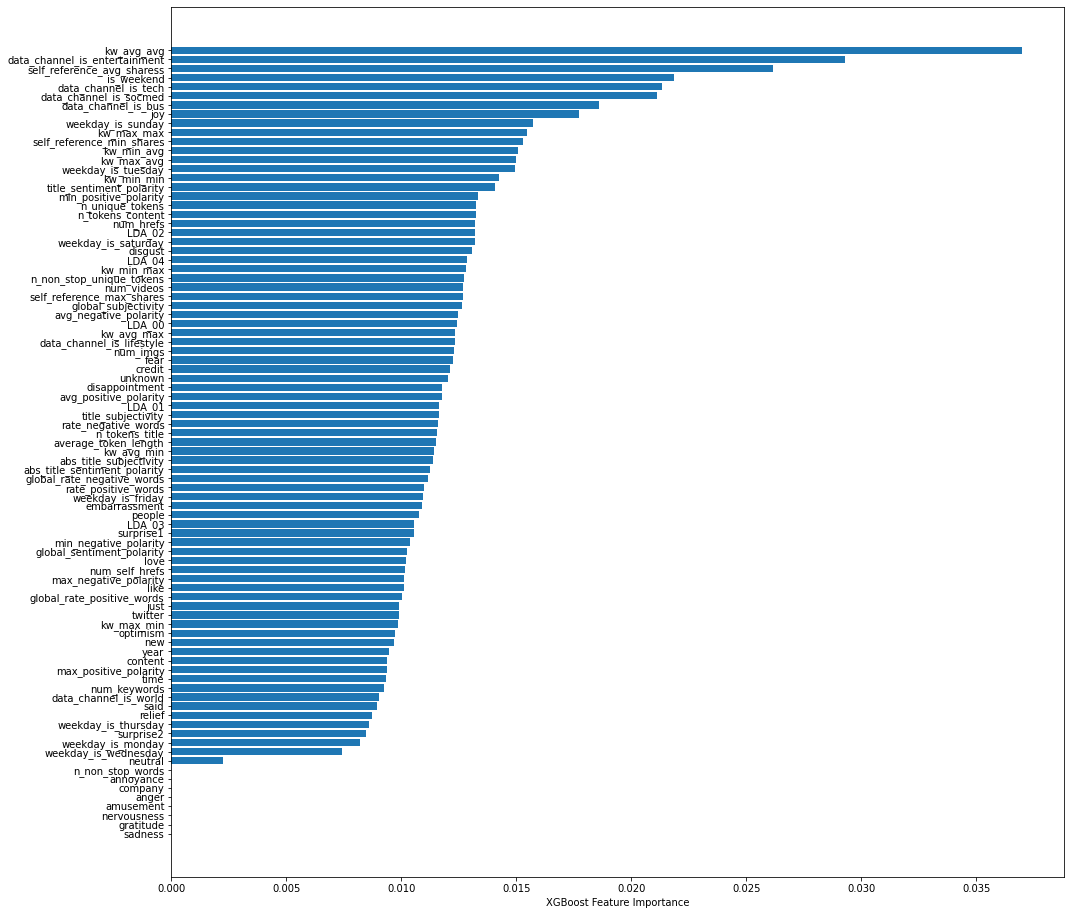

In [500]:
import matplotlib.pyplot as plt

sorted_idx = xgbc.feature_importances_.argsort()
features_importantes = {feature:abs(importance) for feature, importance in zip(xgbc.feature_names_in_[sorted_idx], xgbc.feature_importances_[sorted_idx])}
plt.figure(figsize=(16,16))
plt.barh(xgbc.feature_names_in_[sorted_idx], xgbc.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance");

Elimino features que no tienen importancia

In [501]:
features_no_importantes = [feature for feature, importance in features_importantes.items() if importance == 0]
features_no_importantes

['sadness',
 'gratitude',
 'nervousness',
 'amusement',
 'anger',
 'company',
 'annoyance',
 'n_non_stop_words']

In [502]:
x_train, x_valid = drop_features(
    x_train, x_valid, dropped_features,
    *features_no_importantes
)
fit_and_score(xgbc, x_train, x_valid, y_train.popular, y_valid.popular)

0.6889341234594434

##### Iteración 2: Permutation Importance -> Score: 0.7003086913465073

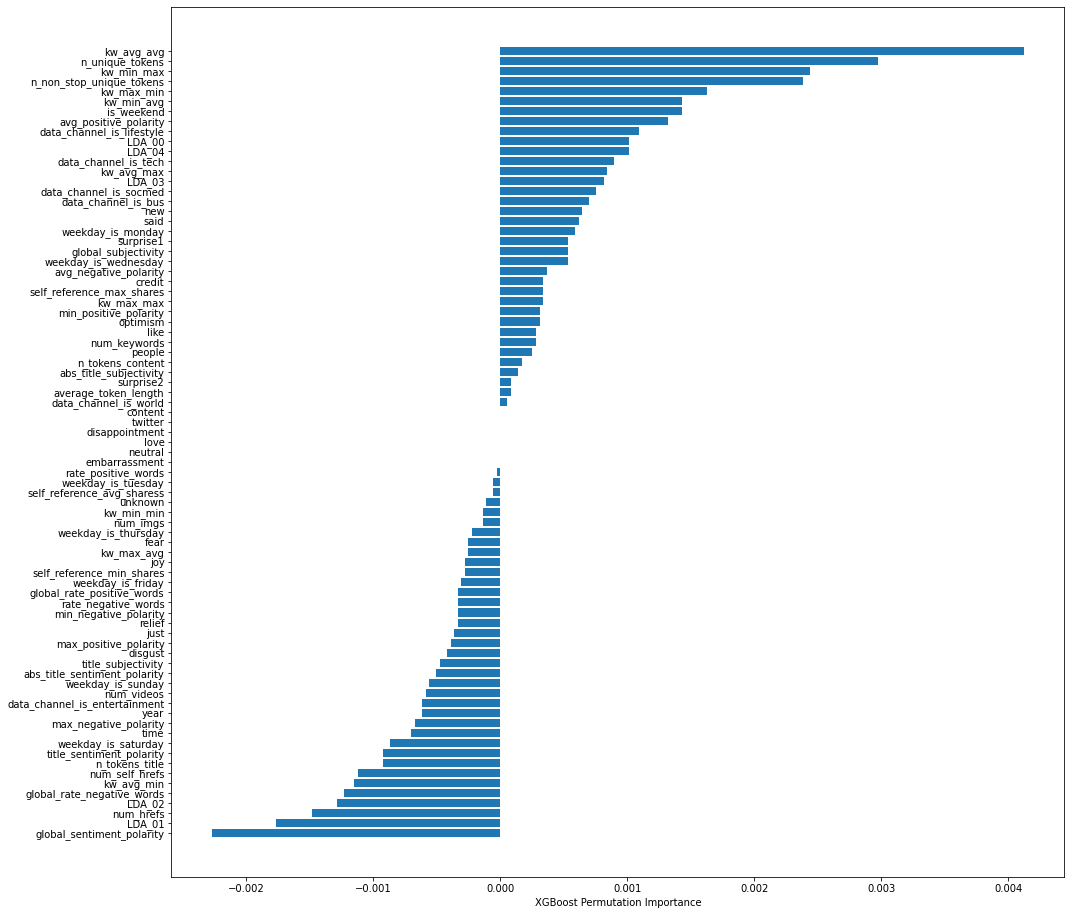

In [503]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xgbc, x_valid, y_valid['popular'], random_state=SEED)

sorted_idx = perm_importance.importances_mean.argsort()

features_importantes = {feature:abs(importance) for feature, importance in zip(xgbc.feature_names_in_[sorted_idx], perm_importance.importances_mean[sorted_idx])}

plt.figure(figsize=(16,16))
plt.barh(xgbc.feature_names_in_[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("XGBoost Permutation Importance");

In [504]:
features_no_importantes = [feature for feature, importance in features_importantes.items() if importance <= 1e-5]
features_no_importantes

['embarrassment', 'neutral', 'love', 'disappointment', 'twitter', 'content']

In [505]:
from itertools import product

def combinacion_de_features_a_eliminar(supuestas_features_a_eliminar, modelo, x_train, x_valid, y_train, y_valid):
    combinaciones_de_supuestas_features_a_eliminar = set(product(*supuestas_features_a_eliminar))
    score_de_combinaciones_de_supuestas_features_a_eliminar = {}
    for combinacion in combinaciones_de_supuestas_features_a_eliminar:
        x_train2, x_valid2 = drop_features(
            x_train, x_valid, set(),
            *combinacion
        )
        score_de_combinaciones_de_supuestas_features_a_eliminar[combinacion] = fit_and_score(modelo, x_train2, x_valid2, y_train, y_valid)
    return score_de_combinaciones_de_supuestas_features_a_eliminar

In [ ]:
matriz_de_features_a_eliminar = [[None for _ in range(len(features_no_importantes))] for _ in range(len(features_no_importantes))]
for i, feature in enumerate(features_no_importantes):
    for j in range(len(features_no_importantes)):
        if i == j:
            matriz_de_features_a_eliminar[i][j] = feature
matriz_de_features_a_eliminar

score_de_combinaciones_de_supuestas_features_a_eliminar = combinacion_de_features_a_eliminar(matriz_de_features_a_eliminar, xgbc, x_train, x_valid, y_train.popular, y_valid.popular)
features_a_doppear = max(score_de_combinaciones_de_supuestas_features_a_eliminar, key=score_de_combinaciones_de_supuestas_features_a_eliminar.get)
features_a_doppear, score_de_combinaciones_de_supuestas_features_a_eliminar[features_a_doppear]

In [507]:
x_train, x_valid = drop_features(
    x_train, x_valid, dropped_features,
    *features_a_doppear
)
fit_and_score(xgbc, x_train, x_valid, y_train.popular, y_valid.popular)

0.6964043197251084

#### Iterando sobre búsqueda de hiperparámetros

##### Iteración 1 -> Score: 0.7218208637740692

```python
hyperparameter_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
}
```

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

hyperparameter_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
}

rscv_xgb = RandomizedSearchCV(
    estimator=xgbc,
    param_distributions=hyperparameter_grid,
    cv=5, n_iter=50,
    scoring = 'roc_auc', n_jobs=-1,
    verbose = 5, 
    random_state=SEED
)

rscv_xgb.fit(x_train ,y_train.popular)
rscv_xgb.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.706 total time=  13.3s
[CV 5/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.691 total time=  13.3s
[CV 3/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.717 total time=  13.5s
[CV 2/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.700 total time=  13.4s
[CV 4/5] END learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=200;, score=0.710 total time=  13.7s
[CV 3/5] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=0.716 total time=  14.6s
[CV 2/5] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=0.701 total time=  14.7s
[CV 1/5] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=0.699 total time=  14.8s
[CV 1/5]

{'n_estimators': 200,
 'min_child_weight': 100,
 'max_depth': 6,
 'learning_rate': 0.05}

In [ ]:
xgbc = XGBClassifier(
    n_estimators=200,
    min_child_weight=100,
    max_depth=6,
    learning_rate=0.05
)
fit_and_score(xgbc, x_train, x_valid, y_train.popular, y_valid.popular)

0.7218208637740692

##### Iteración 2 -> Score: 0.7221223506943724

```py
hyperparameter_grid = {
    'alpha': [0, 2, 4, 6, 8, 10],
    'gamma': [0, 2, 4, 6, 8, 10],
    'lambda': [1, 3, 5, 7, 9],
}
```

In [ ]:
hyperparameter_grid = {
    'alpha': [0, 2, 4, 6, 8, 10],
    'gamma': [0, 2, 4, 6, 8, 10],
    'lambda': [1, 3, 5, 7, 9],
}

random_cv = RandomizedSearchCV(
    estimator=xgbc,
    param_distributions=hyperparameter_grid,
    cv=3, n_iter=50,
    scoring = 'roc_auc', n_jobs=-1,
    verbose = 5, 
    random_state=SEED
)

random_cv.fit(x_train ,y_train.popular)
random_cv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3] END ........alpha=8, gamma=6, lambda=7;, score=0.702 total time=  22.1s
[CV 1/3] END .......alpha=10, gamma=6, lambda=9;, score=0.698 total time=  22.1s
[CV 2/3] END ........alpha=2, gamma=2, lambda=3;, score=0.717 total time=  22.2s
[CV 3/3] END ........alpha=2, gamma=2, lambda=3;, score=0.703 total time=  22.3s
[CV 2/3] END ........alpha=8, gamma=6, lambda=7;, score=0.718 total time=  22.4s
[CV 2/3] END .......alpha=10, gamma=6, lambda=9;, score=0.718 total time=  22.4s
[CV 1/3] END ........alpha=2, gamma=2, lambda=3;, score=0.700 total time=  22.7s
[CV 1/3] END ........alpha=8, gamma=6, lambda=7;, score=0.698 total time=  22.9s
[CV 3/3] END .......alpha=10, gamma=6, lambda=9;, score=0.702 total time=  24.7s
[CV 3/3] END ........alpha=8, gamma=8, lambda=7;, score=0.700 total time=  24.9s
[CV 3/3] END ........alpha=8, gamma=2, lambda=3;, score=0.703 total time=  24.8s
[CV 1/3] END ........alpha=8, gamma=8, lambda=7

{'lambda': 5, 'gamma': 0, 'alpha': 2}

In [110]:
xgbc2 = XGBClassifier(
    reg_lambda=5, 
    gamma=0, 
    alpha=2,
    n_estimators=200,
    min_child_weight=100,
    max_depth=6,
    learning_rate=0.05,
    random_state=SEED
)

fit_and_score(xgbc2, x_train, x_valid, y_train.popular, y_valid.popular)

0.7216539408821881

Bajó el score así que me quedo con la iteración 1.

### Modelo Final -> Score: 0.7221223506943724

In [508]:
from xgboost import XGBClassifier

xgbc_final = XGBClassifier(
    reg_lambda=5, 
    gamma=0, 
    alpha=2,
    n_estimators=200,
    min_child_weight=100,
    max_depth=6,
    learning_rate=0.05,
    random_state=SEED
)
fit_and_score(xgbc_final, x_train, x_valid, y_train.popular, y_valid.popular)

0.7221326078435442

## Model: RandomForestClassifier

### Iteraciones

#### Baseline -> Score: 0.7071820802719608

In [104]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1, random_state=SEED)
fit_and_score(rfc, x_train, x_valid, y_train.popular, y_valid.popular)

0.703637197307254

#### Iterando sobre búsqueda de hiperparámetros

##### Iteración 1 -> Score: 0.718374705870142

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

rfc_hyperparameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [130, 180, 230]
}

rscv = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=rfc_hyperparameters,
    cv=3, n_iter=50,
    scoring = 'roc_auc', n_jobs=-1,
    verbose = 5, 
    random_state=SEED
)

rscv.fit(x_train ,y_train.popular)
rscv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.700 total time=  12.4s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.708 total time=  12.8s
[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.701 total time=  13.0s
[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.695 total time=  14.2s
[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.707 total time=  14.6s
[CV 1/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=230;, score=0.690 total time=  16.6s
[CV 2/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=230;, score=0.707 total

{'n_estimators': 230,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'bootstrap': False}

In [ ]:
rfc2 = RandomForestClassifier(
    n_estimators=230,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=10,
    bootstrap=False,
    random_state=SEED
)
fit_and_score(rfc2, x_train, x_valid, y_train.popular, y_valid.popular)

0.718374705870142

##### Iteración 2 -> Score: 0.718374705870142

In [ ]:
rscv2 = RandomizedSearchCV(
    estimator=rfc2,
    param_distributions=rfc_hyperparameters,
    cv=3, n_iter=50,
    scoring='roc_auc', n_jobs=-1,
    verbose=5, 
    random_state=SEED
)

rscv2.fit(x_train ,y_train.popular)
rscv2.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.701 total time=  13.5s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.708 total time=  13.5s
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=130;, score=0.700 total time=  13.6s
[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.707 total time=  14.6s
[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=130;, score=0.695 total time=  14.6s
[CV 3/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=230;, score=0.692 total time=  17.2s
[CV 2/3] END bootstrap=True, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=230;, score=0.707 total

{'n_estimators': 230,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'bootstrap': False}

In [ ]:
rfc3 = RandomForestClassifier(
    n_estimators=230,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=10,
    bootstrap=False,
    random_state=SEED
)
fit_and_score(rfc3, x_train, x_valid, y_train.popular, y_valid.popular)

0.718374705870142

### Modelo Final -> Score: 0.7229515923613545

Los resultados de la búsqueda dieron unos parámetros que hacían que el score fuera 0.718374705870142. Usando éstos parámetros que conseguí en una búsqueda previa a las últimas el score da más alto, por eso me quedo con ellos.

In [509]:
rfc_final = RandomForestClassifier(
    n_estimators=230,
    min_samples_split=5,
    min_samples_leaf=4,
    max_depth=30,
    bootstrap=False,
    random_state=SEED
)
fit_and_score(rfc_final, x_train, x_valid, y_train.popular, y_valid.popular)

0.7249166911902079

# Comparación de score entre modelos

## XGBClassifier -> Score: 0.7221326078435442
## RandomForestClassifier -> Score: 0.7225197541703248

# Test

In [510]:
test = pd.read_parquet('test')

### popular

In [511]:
y_test = test[['popular']]
y_test.popular = encoders['popular'].transform(y_test.popular)

### surprise1

In [512]:
test['surprise1'] = test['surprise1'].map(surprise1_mean_encoding(test))

### surprise2

In [513]:
test.surprise2 = test.surprise2.map(lambda x: 'unknown' if x == '' else x)
test.surprise2 = test.surprise2.map(lambda x: x.split(','))
encoded_test_surprise2 = encoders['surprise2'].transform(test.surprise2)
surprise2_test_emotions = pd.DataFrame(encoded_test_surprise2, columns=encoders['surprise2'].classes_)
test.surprise2 = encoded_test_surprise2
test = pd.concat([test.reset_index(), surprise2_test_emotions.reset_index()], axis=1)

### content

In [514]:
test['content'] = test['content'].fillna('')
vectorized_test_content = encoders['content'].transform(test['content'].tolist()).toarray()
test_content_word_count = pd.DataFrame(vectorized_test_content, columns=encoders['content'].get_feature_names())
test['content'] = vectorized_test_content
test = pd.concat([test.reset_index(), test_content_word_count.reset_index()], axis=1)

### Feature dropping

In [515]:
if None in dropped_features:
    dropped_features.remove(None)
for feature_a_droppear in dropped_features:
    test.drop(feature_a_droppear, axis=1, inplace=True)

In [516]:
test.fillna(0.0, inplace=True)

In [517]:
fit_and_score(
    model=rfc_final,
    x_train=x_train,
    x_valid=test,
    y_train=y_train.popular,
    y_valid=y_test.popular,
)

0.721592103291332

# Extra

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

logistic_regression = LogisticRegression(random_state=SEED, n_jobs=-1, solver='saga', warm_start=True)
scaler = MinMaxScaler()

fit_and_score(logistic_regression, scaler.fit_transform(x_train), scaler.transform(x_valid), y_train.popular, y_valid.popular)

0.6900445819662222

In [109]:
lr2 = LogisticRegression(
    C=0.8,
    class_weight='balanced',
    dual=False,
    fit_intercept=True,
    l1_ratio=0.9,
    max_iter=200,
    multi_class='multinomial',
    penalty='elasticnet',
    tol=0.0001,
    random_state=SEED, 
    n_jobs=-1, 
    solver='saga', 
    warm_start=True
)
fit_and_score(lr2, scaler.fit_transform(x_train), scaler.transform(x_valid), y_train.popular, y_valid.popular)

0.6989135969502076